In [39]:
# imports and settings
from pandas import DataFrame, melt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# plot settings
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 100

# Binary classification of 2D points arranged in a spiral

## Instructions

Read these carefully to be sure you don't leave anything out.

Start by playing with the 2 class spiral classification problem in the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=35&networkShape=4,2&seed=0.76765&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&problem_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&regularizationRate_hide=true).  Note - this link gives you a reduced version of the original website so you can focus on mainly the structure of the NN for this assignment.  

Don't change the test/training ratio or the noise level.  Also, use only X1 and X2 as features (inputs) for your network.  Experiment with the network structure and try retraining each network a few times until you find a network architecture that seems to work reasonably well.  Once you've done that  you should implement that network here in PyTorch.  

We'll generate the initial spiral data for you.  You do the rest.  You should mimic the setup in the compact version of the logisitic regression notebook from class (in Canvas), but make changes to the network, training loop, etc. as needed.

In addition to plotting the loss for the training and validation sets vs the epochs, figure out how to do the same for accuracy and share that plot.

In the end you should be able to achieve 95% accuracy on the validation data.  I'll likely change a couple of random seeds to see if you've picked a robust architecture and training parameters!

## Step 0 - Prepare the data.

We'll build the spirals.  You'll need to do the splitting into training and validation sets yourself (Use `random_state = 123`).


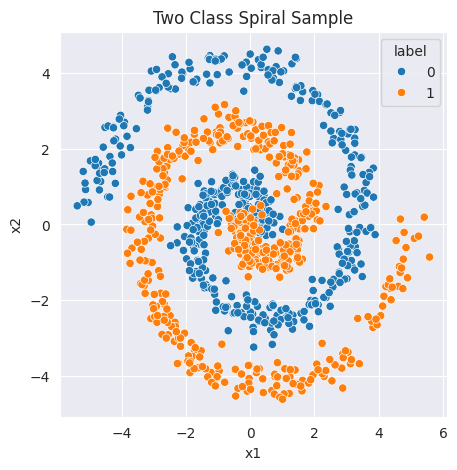

In [40]:
# Execute, but don't change this cell
# These two functions build the two-class spirals
# The data is created and plotted at the end of this cell.

def create_single_spiral( n, std ):

    theta = np.random.uniform( 0, 3*np.pi, n)
    radius = 5*theta/(3*np.pi)
    xx = radius * np.cos(theta) + np.random.normal(0,std,n)
    yy = radius * np.sin(theta) + np.random.normal(0,std,n)
    X = np.transpose(np.stack( [xx, yy]))
    return X

def make_spirals(n_samples = 400, noise = 35, random_state = 42):

    noise = np.clip( noise, 0, 50)
    std = 0.4 * noise/50

    n0 = n_samples // 2
    n1 = n_samples - n0

    np.random.seed(random_state)

    X0 = create_single_spiral( n0, std)
    X1 = -create_single_spiral( n1, std) # rotate 180

    X = np.concatenate([X0, X1], axis = 0)
    y = np.concatenate( [np.zeros(n0), np.ones(n1)] ).astype(int)

    return X,y

X, y = make_spirals(n_samples=1000, noise = 35, random_state = 42)

fig, axes = plt.subplots( figsize = (5,5) )

df = DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))
sns.scatterplot( ax = axes, data = df, x = 'x1', y = 'x2',
                hue = 'label').set(title='Two Class Spiral Sample');

## Step 1 - Define the model in PyTorch.


Describe the model architecture you're building in this text cell and build it in the code cell below:

Instatiate it and view it here:

## Step 2 - Datasets and Dataloaders

Put your custom Dataset here and confirm that it works correctly.  There shouldn't be much to do in this step.

Instantiate a training dataloader and confirm that it works as expected.

## Step 3 - Train the model

Note, you'll need many more epochs than we used in our previous models.  Those problems were easier!  Make sure you modify the previous code to save the accuracy metrics.

**You should be able to achieve 95% or higher accuracy on the validation data.  If you see an epoch in which the validation accuracy is especially high, then you might want to rerun the training with exactly the right number of epochs to end on the high accuracy epoch. This is a crude form of "early stopping."**



Make two plots here.  The first should show the loss vs epoch for both training and validation datasets.  The second is the same, but for accuracy.

## Step 4 - Visualize the results

We modified and left this plotting function for you to help visualize the decision boundary.  The boundary may look a little different on each of the plots because the axis limits change a bit in each plot which changes the grid use to approximate the boundary.

The function `classify_2D_plot` below will help to visualize the results including the model and decision boundary.  It's only intended to work with a PyTorch model that takes two inputs and whose output is in [0,1].

In [ ]:
def classify_2D_plot(ax, pretitle_str, dataset, *model, num_contours = 1, npts = 10):

    x1 = dataset.X[:,0].squeeze().numpy()
    x2 = dataset.X[:,1].squeeze().numpy()

    pad_scale = 0.2
    x1min, x1max = np.min(x1), np.max(x1)
    x1pad = pad_scale*(x1max-x1min)
    x1min, x1max = x1min - pad_scale, x1max + pad_scale
    x2min, x2max = np.min(x2), np.max(x2)
    x2pad = pad_scale*(x2max-x2min)
    x2min, x2max = x2min - pad_scale, x2max + pad_scale
    labels_np = dataset.y.squeeze().numpy().astype(int)
    labels_torch = dataset.y.int()

    # scatter plot, dots colored by class value
    df = DataFrame(dict(x1=x1, x2=x2, label=labels_np))
    sns.scatterplot( ax = ax, x = 'x1', y = 'x2', data = df,
                  hue = 'label').set(title=pretitle_str);
    ax.set_xlim(x1min,x1max)
    ax.set_ylim(x2min,x2max)

    if len(model) > 0:
        model = model[0]

        # compute the accuracy on the data
        yhat = model(dataset.X.to(device)).cpu()
        pred = (yhat >= 0.5).int()
        accuracy = 100*torch.sum(pred==labels_torch)/len(labels_torch)
        title_str = f'{pretitle_str}, Acc = {accuracy:.1f}%'

        # plot the decision boundary and the fills
        x1_ls = torch.linspace(x1min,x1max,npts).float()
        x2_ls = torch.linspace(x2min,x2max,npts).float()
        x1_mg, x2_mg = torch.meshgrid( x1_ls, x2_ls )
        grid = torch.stack( (x1_mg.flatten(), x2_mg.flatten() ), dim = 1)
        grid = grid.to(device)
        with torch.no_grad():
            z = model(grid).reshape(npts,npts).cpu()
        ax.contourf(x1_mg.numpy(), x2_mg.numpy(), z.numpy(), 1, alpha = 0.3, cmap = 'seismic')
        ax.set_title(title_str)


fig, axes = plt.subplots(1, 2, figsize=(10,5))
classify_2D_plot(axes[0],'Training Set',dset_train,model,npts=30)
classify_2D_plot(axes[1],'Validation Set',dset_valid,model, npts = 30)